# Algoritma K-Means

## Pengertian K-Means Clustering

K-Means Clustering merupakan salah satu metode pengelompokan data yang bekerja dengan memisahkan data ke dalam beberapa cluster berdasarkan kemiripan fitur. Data yang memiliki karakteristik serupa akan dikelompokkan dalam cluster yang sama, sementara data yang berbeda cirinya akan ditempatkan dalam cluster yang berbeda. Proses ini menggunakan titik pusat (centroid) sebagai acuan dalam pembentukan cluster.

Clustering yang efektif akan menghasilkan kelompok dengan tingkat kemiripan tinggi di dalam cluster dan perbedaan yang signifikan antar cluster. Kemiripan yang dimaksud diukur secara numerik antara dua objek, di mana semakin mirip dua objek tersebut, maka nilai kesamaannya akan semakin tinggi. Sebaliknya, semakin berbeda dua objek, semakin rendah nilai kesamaannya. Oleh karena itu, kualitas hasil clustering sangat ditentukan oleh metode yang digunakan.

## Inertia (Sum Square error/SSE)


Dalam konteks algoritma K-Means Clustering, inertia (Sum Square error/SSE) adalah salah satu metrik evaluasi untuk menilai seberapa baik data dikelompokkan ke dalam klaster serta mengukur jumlah total jarak kuadrat antara setiap titik data dan pusat klaster (centroid) tempat titik tersebut.

Inertia didefinisikan sebagai:

$$
\text{Inertia} = \sum_{i=1}^{n} \left\| x_i - \mu_{c_i} \right\|^2
$$

**Penjelasan Notasi**
- $x_i$: Titik data ke-$i$
- $\mu_{c_i}$: Centroid dari klaster tempat $x_i$ berada
- $\left\| x_i - \mu_{c_i} \right\|^2$: Jarak Euclidean kuadrat antara $x_i$ dan centroid-nya
- $n$: Jumlah total data

## Silhouette Analysis


Silhouette Analysis adalah metrik evaluasi lain yang lebih baik dari inertia dalam banyak kasus untuk mengevaluasi hasil clustering, seperti pada K-Means, karena mempertimbangkan dua hal sekaligus yaitu:

- Kepadatan dalam klaster

- Jarak antar klaster

Silhouette Analysis mengukur seberapa mirip suatu titik data dengan klasternya sendiri dibandingkan dengan klaster terdekat lainnya. Rumusnya adalah:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

**Penjelasan Notasi**:
- $a(i)$: Rata-rata jarak dari titik $i$ ke semua titik lain dalam klaster yang sama (cohesion)
- $b(i)$: Rata-rata jarak dari titik $i$ ke semua titik dalam klaster terdekat yang bukan miliknya (separation)
- $s(i)$: Skor silhouette untuk titik $i$, dengan nilai antara -1 dan 1

Nilai skor $s(i)$ ditafsirkan sebagai berikut:
- Jika $s(i) \approx 1$, maka titik berada jauh dari klaster lain dan cocok dengan klasternya
- Jika $s(i) \approx 0$, maka titik berada di antara dua klaster
- Jika $s(i) \approx -1$, maka titik bisa jadi salah masuk klaster

Untuk mengevaluasi seluruh hasil clustering, digunakan rata-rata dari semua $s(i)$:

$$
S = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

- $n$: Jumlah total data
- $S$: Silhouette score rata-rata seluruh data


## Implementasi dengan menggunakan data Iris

In [20]:
%pip install pymysql
%pip install psycopg2

## Library yang digunakan

In [21]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

## Ambil dan Gabungkan Data dari Database

In [22]:
def get_pg_data():
    conn = psycopg2.connect(
        host="postgresqltest-projectadzin.i.aivencloud.com",
        user="avnadmin",
        password="AVNS_k58rpi0pi31N8ucX-vK",
        database="defaultdb",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM sepal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-386c0068-projectadzin.l.aivencloud.com",
        user="avnadmin",
        password="AVNS_-Zr6_we8osFXobQb3qi",
        database="iris",
        port=16209
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM petal")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Cetak semua data hasil gabungan tanpa indeks
display(HTML(df_merged.to_html(index=False)))

id,class,petal_length,petal_width,sepal_length,sepal_width
1,Iris-setosa,1.4,0.2,5.1,3.5
2,Iris-setosa,14.0,2.0,40.9,30.0
3,Iris-setosa,1.3,0.2,4.7,3.2
4,Iris-setosa,15.0,2.0,46.0,31.0
5,Iris-setosa,1.4,0.2,5.0,3.6
6,Iris-setosa,1.7,0.4,5.4,3.9
7,Iris-setosa,1.4,0.3,4.6,3.4
8,Iris-setosa,1.5,0.2,5.0,3.4
9,Iris-setosa,1.4,0.2,4.4,2.9
10,Iris-setosa,1.5,0.1,4.9,3.1


## Data asli sebelum di normalisasi

Ini adalah data sebelum normalisasi

In [23]:
# Ambil hanya fitur numerik (hapus kolom non-numerik)
features_before_scaling = df_merged.drop(columns=['id', 'class'])

print (features_before_scaling.to_string(index=False))

 petal_length  petal_width  sepal_length  sepal_width
          1.4          0.2           5.1          3.5
         14.0          2.0          40.9         30.0
          1.3          0.2           4.7          3.2
         15.0          2.0          46.0         31.0
          1.4          0.2           5.0          3.6
          1.7          0.4           5.4          3.9
          1.4          0.3           4.6          3.4
          1.5          0.2           5.0          3.4
          1.4          0.2           4.4          2.9
          1.5          0.1           4.9          3.1
          1.5          0.2           5.4          3.7
         16.0          2.0          48.0         34.0
          1.4          0.1           4.8          3.0
          1.1          0.1           4.3          3.0
          1.2          0.2           5.8          4.0
          1.5          0.4           5.7          4.4
          1.3          0.4           5.4          3.9
          1.4          0.3  

## Visualisasi data

### Visualisasi data asli tanpa menggunakan PCA

Ini adalah visualisasi data Iris secara 2 Dimensi tanpa menggunakan PCA

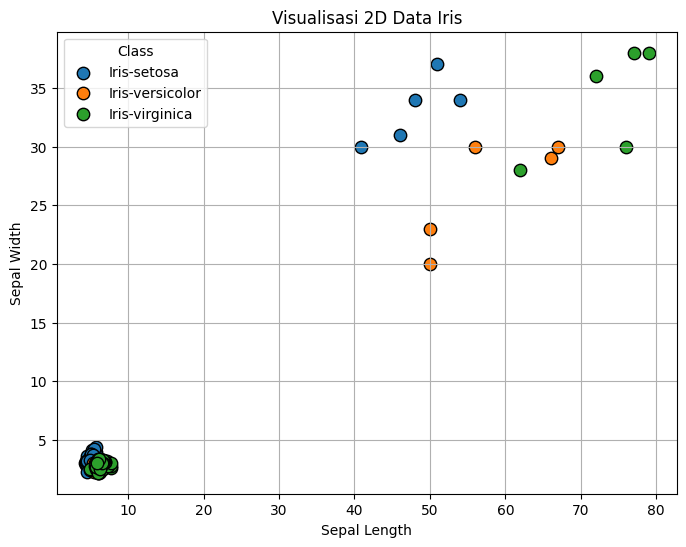

In [24]:
# Ubah kolom 'class' menjadi kategori jika belum
df_merged['class'] = df_merged['class'].astype('category')

# Plot 2D scatter plot
plt.figure(figsize=(8, 6))
for label in df_merged['class'].cat.categories:
    subset = df_merged[df_merged['class'] == label]
    plt.scatter(subset['sepal_length'], subset['sepal_width'], label=label, s=80, edgecolors='k')

plt.title("Visualisasi 2D Data Iris")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend(title='Class')
plt.grid(True)
plt.show()


Ini adalah visualisasi data Iris secara 3 Dimensi tanpa menggunakan PCA

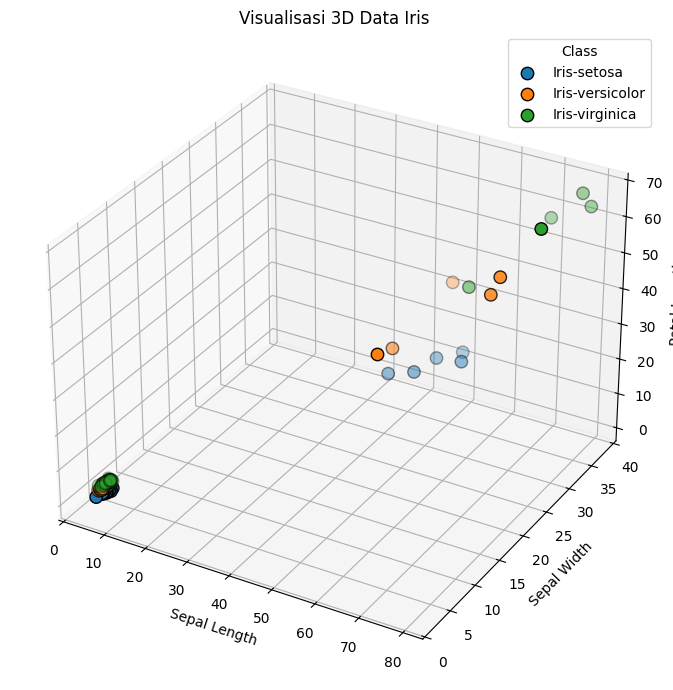

In [25]:
df_merged['class'] = df_merged['class'].astype('category')

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for label in df_merged['class'].cat.categories:
    subset = df_merged[df_merged['class'] == label]
    ax.scatter(
        subset['sepal_length'],
        subset['sepal_width'],
        subset['petal_length'],
        label=label,
        s=80,
        edgecolors='k'
    )

ax.set_title("Visualisasi 3D Data Iris")
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_zlabel("Petal Length")
ax.legend(title='Class')
plt.tight_layout()
plt.show()

### Visualisasi data asli menggunakan PCA

Ini adalah visualisasi data Iris secara 2 Dimensi menggunakan PCA

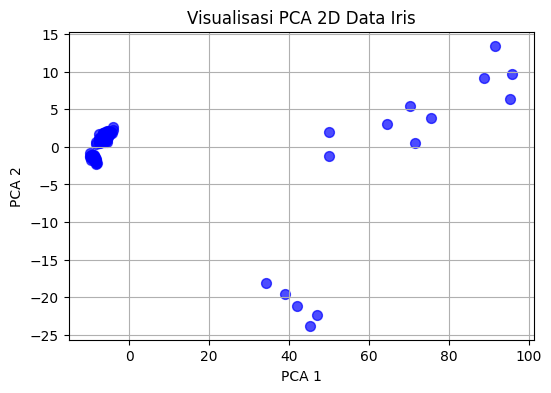

In [26]:
# Ambil hanya fitur numerik (hapus kolom non-numerik)
features_before_scaling = df_merged.drop(columns=['id', 'class'])

# PCA langsung pada data mentah (belum dinormalisasi)
pca_raw = PCA(n_components=2)
reduced_raw = pca_raw.fit_transform(features_before_scaling)

# Visualisasi 2D hasil PCA sebelum normalisasi
plt.figure(figsize=(6, 4))
plt.scatter(reduced_raw[:, 0], reduced_raw[:, 1], c='blue', s=50, alpha=0.7)
plt.title("Visualisasi PCA 2D Data Iris")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

Ini adalah visualisasi data Iris secara 3 Dimensi menggunakan PCA

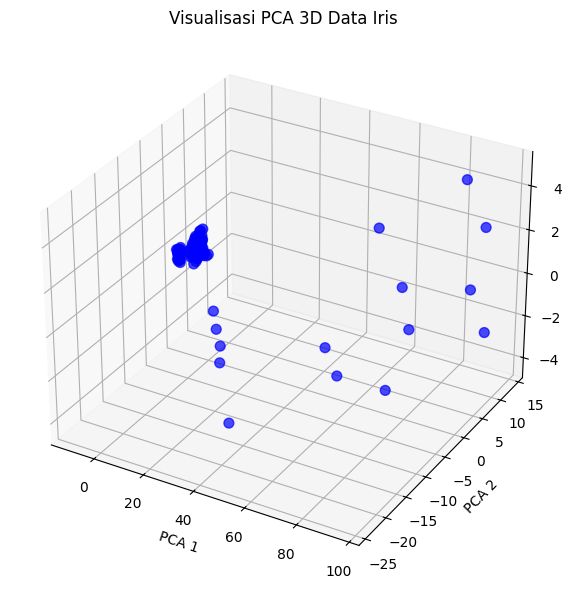

In [27]:
# Ambil hanya fitur numerik (hapus kolom non-numerik)
features_before_scaling = df_merged.drop(columns=['id', 'class'])

# PCA ke 3 komponen tanpa normalisasi
pca_raw_3d = PCA(n_components=3)
reduced_raw_3d = pca_raw_3d.fit_transform(features_before_scaling)

# Visualisasi 3D hasil PCA sebelum normalisasi
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    reduced_raw_3d[:, 0],
    reduced_raw_3d[:, 1],
    reduced_raw_3d[:, 2],
    c='blue',
    s=50,
    alpha=0.7
)

ax.set_title("Visualisasi PCA 3D Data Iris")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.grid(True)
plt.tight_layout()
plt.show()


## Preprocessing dan Reduksi Dimensi

### Normalisasi dengan MinMaxScaler

Saya menerapkan normalisasi menggunakan MinMaxScaler untuk menyelaraskan skala seluruh fitur dalam dataset. Langkah ini krusial karena fitur-fitur dalam data memiliki rentang nilai yang bervariasi, yang bisa memengaruhi performa algoritma machine learning, terutama yang bergantung pada perhitungan jarak seperti KNN dan SVM.

MinMaxScaler bekerja dengan mentransformasikan setiap nilai fitur ke dalam rentang antara 0 hingga 1, berdasarkan nilai minimum dan maksimum fitur tersebut. Dengan skala yang seragam, setiap fitur dapat diproses secara setara oleh algoritma, tanpa adanya dominasi dari fitur dengan nilai yang lebih besar.

Setelah normalisasi diterapkan, saya melihat bahwa model menjadi lebih stabil dan performanya meningkat. Dari pengalaman ini, saya menyadari bahwa proses normalisasi bukan sekadar langkah teknis, melainkan bagian penting dalam memastikan kualitas dan keandalan data untuk pembelajaran mesin.


In [28]:
# Drop kolom non-numerik
features = df_merged.drop(columns=['id', 'class'])

# Normalisasi dengan MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Reduksi dimensi untuk visualisasi
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(scaled_features)


Berikut adalah data hasil standarisasi menggunakan MinMaxScaler

In [29]:
print (scaled_features)

[[0.00606061 0.00401606 0.0107095  0.03631285]
 [0.1969697  0.07630522 0.48995984 0.77653631]
 [0.00454545 0.00401606 0.00535475 0.02793296]
 [0.21212121 0.07630522 0.55823293 0.80446927]
 [0.00606061 0.00401606 0.00937082 0.03910615]
 [0.01060606 0.01204819 0.01472557 0.04748603]
 [0.00606061 0.00803213 0.00401606 0.03351955]
 [0.00757576 0.00401606 0.00937082 0.03351955]
 [0.00606061 0.00401606 0.00133869 0.01955307]
 [0.00757576 0.         0.00803213 0.02513966]
 [0.00757576 0.00401606 0.01472557 0.04189944]
 [0.22727273 0.07630522 0.58500669 0.88826816]
 [0.00606061 0.         0.00669344 0.02234637]
 [0.00151515 0.         0.         0.02234637]
 [0.0030303  0.00401606 0.02008032 0.05027933]
 [0.00757576 0.01204819 0.01874163 0.06145251]
 [0.00454545 0.01204819 0.01472557 0.04748603]
 [0.00606061 0.00803213 0.0107095  0.03631285]
 [0.01060606 0.00803213 0.01874163 0.04469274]
 [0.00757576 0.00803213 0.0107095  0.04469274]
 [0.24242424 0.07630522 0.66532798 0.88826816]
 [0.21212121 

## Clustering menggunakan K-Means

### Clustering dengan 2 cluster dan Visualisasi data

Disini saya melakukan clustering menggunakan K-Means dengan 2 cluster sekaligus menghitung Inertia dan Silhouette Score, lalu melakukan visualisasi 2 Dimensi pada data Iris setelah clustering

[2 Clusters] Inertia: 3.7984, Silhouette Score: 0.9150


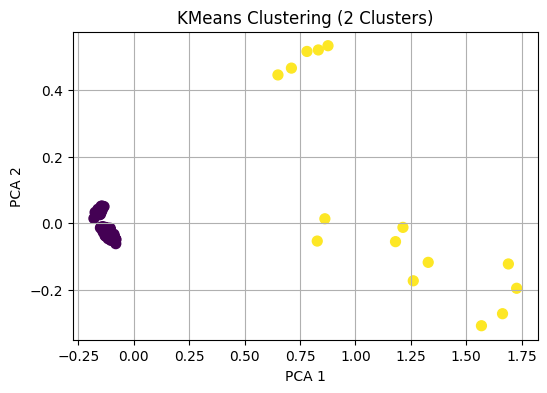

In [30]:
# KMeans dengan 2 cluster
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_2 = kmeans_2.fit_predict(scaled_features)

# Metode evaluasi
inertia_2 = kmeans_2.inertia_
silhouette_2 = silhouette_score(scaled_features, labels_2)

print(f"[2 Clusters] Inertia: {inertia_2:.4f}, Silhouette Score: {silhouette_2:.4f}")

# Visualisasi
plt.figure(figsize=(6, 4))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_2, cmap='viridis', s=50)
plt.title("KMeans Clustering (2 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


Berikut juga saya lakukan visualisasi 3 Dimensi pada data Iris setelah clustering

[2 Clusters] Inertia: 3.7984, Silhouette Score: 0.9150


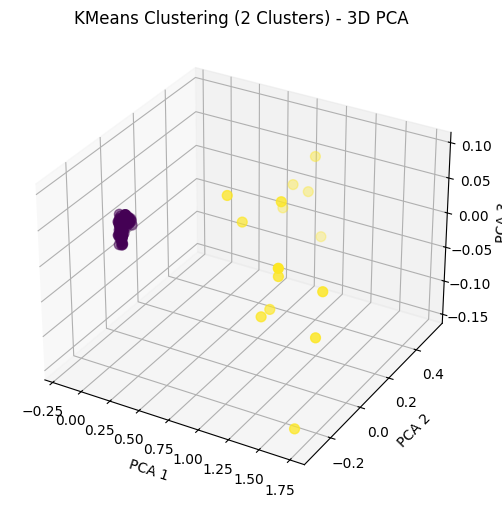

In [31]:
# PCA dengan 3 komponen untuk visualisasi 3D
pca_3d = PCA(n_components=3)
reduced_features_3d = pca_3d.fit_transform(scaled_features)

# KMeans dengan 2 cluster
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_2 = kmeans_2.fit_predict(scaled_features)

# Metode evaluasi
inertia_2 = kmeans_2.inertia_
silhouette_2 = silhouette_score(scaled_features, labels_2)

print(f"[2 Clusters] Inertia: {inertia_2:.4f}, Silhouette Score: {silhouette_2:.4f}")

# Visualisasi 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_features_3d[:, 0],
    reduced_features_3d[:, 1],
    reduced_features_3d[:, 2],
    c=labels_2, cmap='viridis', s=50
)

ax.set_title("KMeans Clustering (2 Clusters) - 3D PCA")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.grid(True)
plt.show()


### Clustering dengan 3 cluster dan Visualisasi data

Disini saya melakukan clustering menggunakan K-Means dengan 3 cluster sekaligus menghitung Inertia dan Silhouette Score, lalu melakukan visualisasi 2 Dimensi pada data Iris setelah clustering

[3 Clusters] Inertia: 1.1985, Silhouette Score: 0.9121


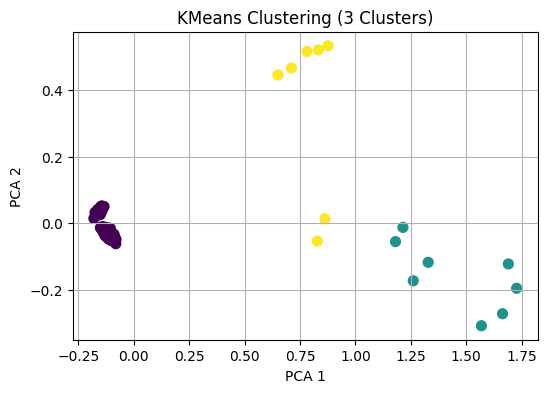

In [32]:
# KMeans dengan 3 cluster
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(scaled_features)

inertia_3 = kmeans_3.inertia_
silhouette_3 = silhouette_score(scaled_features, labels_3)

print(f"[3 Clusters] Inertia: {inertia_3:.4f}, Silhouette Score: {silhouette_3:.4f}")

plt.figure(figsize=(6, 4))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_3, cmap='viridis', s=50)
plt.title("KMeans Clustering (3 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


Berikut juga saya lakukan visualisasi 3 Dimensi pada data Iris setelah clustering

[3 Clusters] Inertia: 1.1985, Silhouette Score: 0.9121


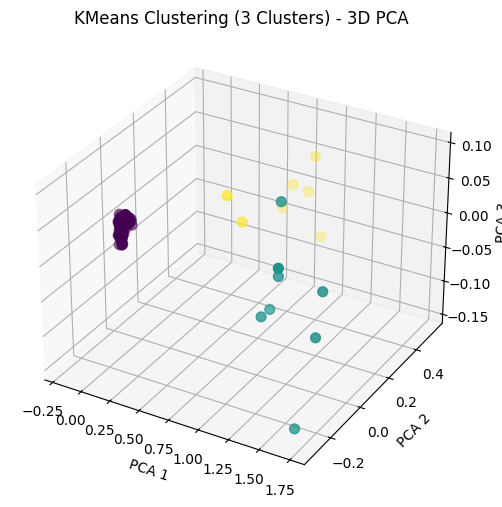

In [33]:
# PCA dengan 3 komponen
pca_3d = PCA(n_components=3)
reduced_features_3d = pca_3d.fit_transform(scaled_features)

# KMeans dengan 3 cluster
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(scaled_features)

# Evaluasi
inertia_3 = kmeans_3.inertia_
silhouette_3 = silhouette_score(scaled_features, labels_3)

print(f"[3 Clusters] Inertia: {inertia_3:.4f}, Silhouette Score: {silhouette_3:.4f}")

# Visualisasi 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_features_3d[:, 0],
    reduced_features_3d[:, 1],
    reduced_features_3d[:, 2],
    c=labels_3,
    cmap='viridis',
    s=50
)

ax.set_title("KMeans Clustering (3 Clusters) - 3D PCA")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.grid(True)
plt.show()


### Clustering dengan 4 cluster dan Visualisasi data

Disini saya melakukan clustering menggunakan K-Means dengan 4 cluster sekaligus menghitung Inertia dan Silhouette Score, lalu melakukan visualisasi 2 Dimensi pada data Iris setelah clustering

[4 Clusters] Inertia: 0.6380, Silhouette Score: 0.9138


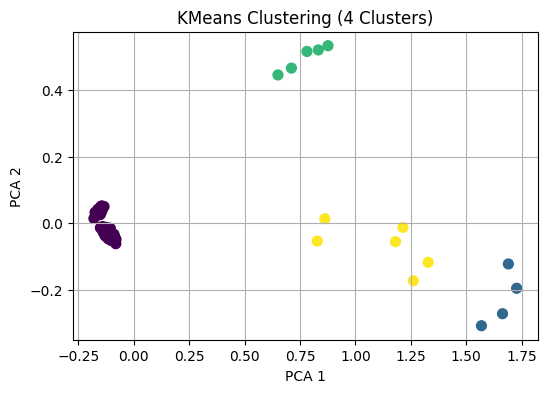

In [34]:
# KMeans dengan 4 cluster
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(scaled_features)

inertia_4 = kmeans_4.inertia_
silhouette_4 = silhouette_score(scaled_features, labels_4)

print(f"[4 Clusters] Inertia: {inertia_4:.4f}, Silhouette Score: {silhouette_4:.4f}")

plt.figure(figsize=(6, 4))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_4, cmap='viridis', s=50)
plt.title("KMeans Clustering (4 Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

Berikut juga saya lakukan visualisasi 3 Dimensi pada data Iris setelah clustering

[4 Clusters] Inertia: 0.6380, Silhouette Score: 0.9138


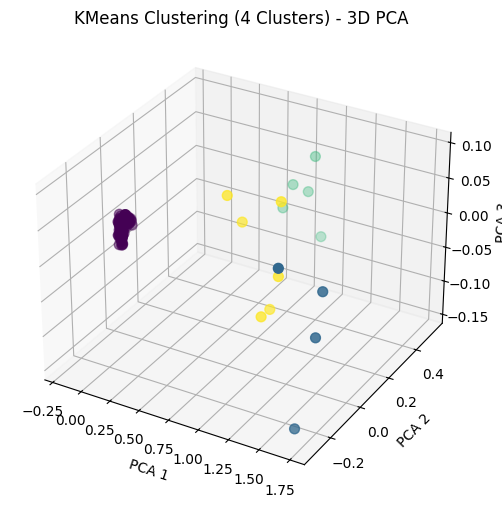

In [35]:
# PCA dengan 3 komponen
pca_3d = PCA(n_components=3)
reduced_features_3d = pca_3d.fit_transform(scaled_features)

# KMeans dengan 4 cluster
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(scaled_features)

inertia_4 = kmeans_4.inertia_
silhouette_4 = silhouette_score(scaled_features, labels_4)

print(f"[4 Clusters] Inertia: {inertia_4:.4f}, Silhouette Score: {silhouette_4:.4f}")

# Visualisasi 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_features_3d[:, 0],
    reduced_features_3d[:, 1],
    reduced_features_3d[:, 2],
    c=labels_4,
    cmap='viridis',
    s=50
)

ax.set_title("KMeans Clustering (4 Clusters) - 3D PCA")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.grid(True)
plt.show()
